<a href="https://colab.research.google.com/github/mukta121/DeepLearning_AutoEncoder/blob/master/Varational_autoencoder_on_tabular_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q --upgrade tf-nightly==1.14.1-dev20190312 #tf-nightly-gpu==1.14.1-dev20190312
!pip install -q tfp-nightly==0.7.0.dev20190312

     |████████████████████████████████| 98.4MB 2.8MB/s 
     |████████████████████████████████| 3.2MB 37.4MB/s 
     |████████████████████████████████| 460kB 42.2MB/s 
     |████████████████████████████████| 870kB 3.4MB/s 


#Credit Card Fraud Detection

In [0]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

In [0]:
import numpy as np
import tensorflow as tf
from tensorflow.python import tf2
if not tf2.enabled():
    import tensorflow.compat.v2 as tf
    tf.enable_v2_behavior()
    assert tf2.enabled()

# import tensorflow_datasets as tfds
import tensorflow_probability as tfp

tfk = tf.keras
tfkl = tf.keras.layers
tfpl = tfp.layers
tfd = tfp.distributions

In [0]:
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, roc_curve
from sklearn.preprocessing import MinMaxScaler
from sklearn.manifold import TSNE
import os

In [27]:
%matplotlib inline
np.random.seed(0)
#tf.random.set_seed(0)
print(tf.__version__)
print(tfp.__version__)

1.14.1-dev20190312
0.7.0-dev


In [0]:
### Utility Functions
## Plots
###Plot Feature Projection 
def tsne_plot(x1, y1, name="graph.png"):
    tsne = TSNE(n_components=2, random_state=0)
    X_t = tsne.fit_transform(x1)
    plt.figure(figsize=(12, 8))
    plt.scatter(X_t[np.where(y1 == 0), 0], X_t[np.where(y1 == 0), 1], marker='o', color='g', linewidth='1', alpha=0.8, label='Non Fraud', s=2)
    plt.scatter(X_t[np.where(y1 == 1), 0], X_t[np.where(y1 == 1), 1], marker='o', color='r', linewidth='1', alpha=0.8, label='Fraud', s=2)
    plt.legend(loc='best');
    plt.savefig(name);
    plt.show();
    
# Plot Keras training history
def plot_loss(hist):
    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.yscale('log',basey=10)
    plt.show()

In [0]:
##for less than 25MB
#url='https://drive.google.com/open?id=1fT67WS0yRTYfb5NBAYseexH_OALycz0c'
#raw_data = pd.read_csv(url)
#raw_data

In [19]:
from google.colab import files
uploaded = files.upload()

Saving creditcard.csv to creditcard.csv


In [0]:
import io
raw_data = pd.read_csv(io.BytesIO(uploaded['creditcard.csv']))

In [0]:
raw_data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [0]:
data, data_test = train_test_split(raw_data, test_size=0.25)

In [30]:
print(data.shape)
print(data_test.shape)

(213605, 31)
(71202, 31)


In [31]:
data.loc[:,"Time"] = data["Time"].apply(lambda x : x / 3600 % 24)
data.loc[:,'Amount'] = np.log(data['Amount']+1)

data_test.loc[:,"Time"] = data_test["Time"].apply(lambda x : x / 3600 % 24)
data_test.loc[:,'Amount'] = np.log(data_test['Amount']+1)
#data = data.drop(['Amount'], axis = 1)
print(data.shape)
data.head()

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


(213605, 31)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
194763,12.318611,2.047163,0.107987,-1.806515,0.072733,0.248371,-1.744837,0.712448,-0.488842,-0.102709,0.181618,1.631225,1.176142,-0.241013,1.040992,-0.328446,-0.673208,-0.245852,-0.331582,0.113072,-0.261380,0.241017,0.822618,0.023000,0.549868,0.322173,0.191755,-0.085025,-0.084292,0.570980,0
135660,22.595556,1.282404,0.459864,-0.372286,0.826375,0.463568,-0.466407,0.460867,-0.186469,-0.549700,0.203961,0.787663,0.882770,0.417271,0.642625,-0.010424,0.161875,-0.835298,0.302139,0.293010,-0.096751,0.013986,0.083896,-0.247504,-0.325527,0.927293,-0.272555,-0.010168,-0.005332,1.026042,0
259186,20.167778,-0.414863,0.012026,1.356386,1.107374,0.813456,-0.156497,-0.372675,0.031095,-0.100143,-0.158606,-1.137380,0.674799,2.027621,-0.272567,1.802644,-0.812031,0.098509,0.376851,2.958766,0.564341,-0.052272,-0.088160,0.062521,-0.680805,-0.641474,-0.159995,0.237628,0.204343,1.938742,0
87387,17.128333,-1.432948,1.478076,0.576724,0.207540,-0.670662,-0.464572,0.221023,-0.099811,1.561896,1.511193,-0.029435,0.710931,0.088355,-0.913471,-0.376058,-0.992295,0.361036,-1.219535,-0.514430,0.266179,-0.055014,0.364330,0.154670,0.635611,-0.366314,0.163690,-0.750285,-0.275117,2.322388,0
267282,21.195278,2.051016,-0.016765,-2.284865,0.302168,0.786895,-0.998558,0.768990,-0.464383,0.362863,-0.031401,-1.124247,0.263750,-0.036857,0.617273,-0.146163,-0.774674,-0.240874,-0.438419,0.273518,-0.139341,0.133331,0.491780,-0.119020,0.527179,0.607105,-0.090453,-0.065787,-0.062680,3.882182,0


In [0]:
non_fraud = data[data['Class'] == 0].sample(1000)
fraud = data[data['Class'] == 1]
df = non_fraud.append(fraud).sample(frac=1).reset_index(drop=True)

In [33]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,12.119444,-0.237432,0.841994,-0.873499,-0.987010,1.686711,1.196473,0.485981,0.595062,0.157745,-0.439106,0.862478,-0.205000,-1.594901,-0.530732,0.058503,-0.115990,0.805962,-0.693983,-0.800050,-0.025578,-0.299184,-0.646481,0.116880,-1.093683,-0.588950,0.234334,0.370088,0.112346,1.851599,0
1,2.347500,0.314597,2.660670,-5.920037,4.522500,-2.315027,-2.278352,-4.684054,1.202270,-0.694696,-5.526278,6.662437,-8.525465,0.742745,-7.678668,0.593070,-4.478137,-5.844266,-1.102731,2.177386,0.562706,0.743314,0.064038,0.677842,0.083008,-1.911034,0.322188,0.620867,0.185030,0.693147,1
2,16.800000,1.175940,-0.159485,-1.213320,0.301701,2.141847,3.623126,-0.379087,0.837418,0.167131,-0.039339,-0.541686,0.237992,-0.214755,0.201722,-0.145469,-0.095333,-0.509491,-0.067061,0.349125,0.053328,-0.156026,-0.504686,-0.166470,1.012198,0.876597,-0.331453,0.016793,0.020333,4.000583,0
3,8.136389,-1.550273,1.088689,-2.393388,1.008733,-1.087562,-1.104602,-2.670503,0.147655,-0.978626,-3.514133,3.586042,-4.053358,0.862426,-5.765823,-0.507511,-4.921865,-9.567268,-2.772974,1.717095,0.327490,0.802316,1.037105,0.095815,-0.320191,-0.080731,0.091012,0.024928,-0.077820,2.893700,1
4,9.862778,2.193770,-1.594469,-0.316619,-1.429214,-1.773657,-0.497934,-1.533021,-0.085693,-0.878787,1.521359,-0.747380,-0.592949,0.750439,-0.764173,0.098069,-0.371368,0.441160,0.297431,-0.566960,-0.340137,0.138634,0.892122,0.201487,1.168394,-0.236176,-0.022404,0.036604,-0.025818,3.761200,0


In [0]:
X = df.drop(['Class'], axis = 1).values
Y = df["Class"].values

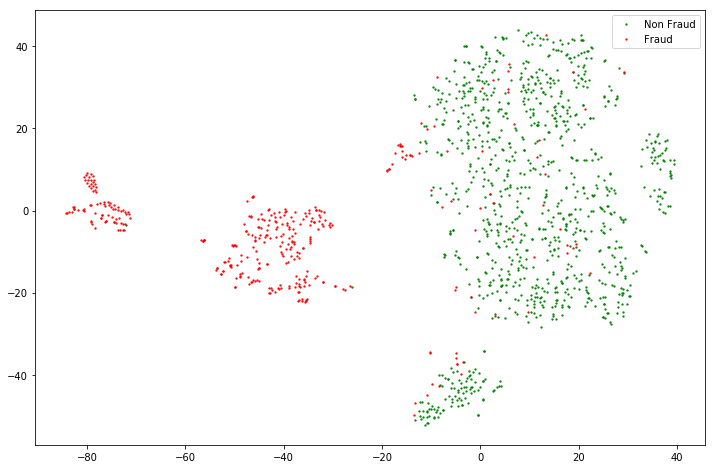

In [35]:
tsne_plot(X, Y, "original.png")

In [0]:
def dense_layers(sizes):
    return tfk.Sequential([tfkl.Dense(size, activation=tf.nn.leaky_relu) for size in sizes])

In [0]:
original_dim = X.shape[1]
input_shape = X[0].shape
intermediary_dims = [20, 10, 8]
latent_dim = 2
batch_size = 128
max_epochs = 1000

In [0]:
prior = tfd.MultivariateNormalDiag(loc=tf.zeros([latent_dim]),scale_identity_multiplier=1.0)

In [0]:
tfk = tf.keras
tfkl = tf.keras.layers
tfpl = tfp.layers
tfd = tfp.distributions

In [0]:
encoder = tf.keras.Sequential([tf.keras.layers.InputLayer(input_shape=input_shape, name='encoder_input'),
                               dense_layers(intermediary_dims),tf.keras.layers.Dense(tfp.layers.MultivariateNormalTriL.params_size(latent_dim), activation=None),
    tfp.layers.MultivariateNormalTriL(latent_dim, activity_regularizer=tfp.layers.KLDivergenceRegularizer(prior)),], name='encoder')

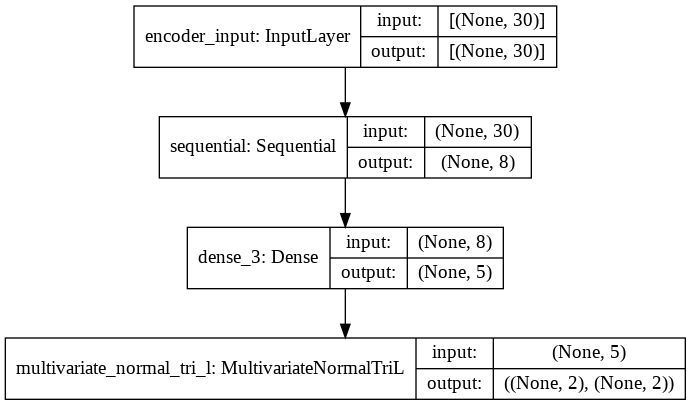

In [41]:
plot_model(encoder, to_file='vae_mlp_encoder.png', show_shapes=True)

In [0]:
# encoder = tfk.Sequential([
#     tfkl.InputLayer(input_shape=input_shape, name='encoder_input'),
#     dense_layers(intermediary_dims),
#     tfkl.Dense(tfpl.MultivariateNormalTriL.params_size(latent_dim), activation=None),
#     tfpl.MultivariateNormalTriL(latent_dim, 
#                            activity_regularizer=tfpl.KLDivergenceRegularizer(prior)),
# ], name='encoder')

In [0]:
# list(reversed(intermediary_dims))[8,10,20]
# input_shape=[latent_dim] [2]
# print(input_shape)
# list(dense_layers(reversed(intermediary_dims)))

In [0]:
decoder = tfk.Sequential([
    tfkl.InputLayer(input_shape=[latent_dim]),
    dense_layers(reversed(intermediary_dims)),
    tfkl.Dense(tfpl.IndependentNormal.params_size(original_dim), activation=None),
    tfpl.IndependentNormal(original_dim),
], name='decoder')

In [44]:
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 20)                334       
_________________________________________________________________
dense_7 (Dense)              (None, 60)                1260      
_________________________________________________________________
independent_normal (Independ ((None, 30), (None, 30))  0         
Total params: 1,594
Trainable params: 1,594
Non-trainable params: 0
_________________________________________________________________


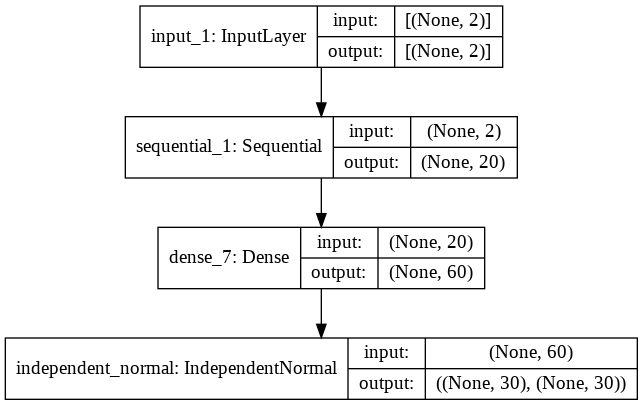

In [45]:
plot_model(decoder, to_file='vae_mlp_decoder.png', show_shapes=True)

In [0]:
vae = tfk.Model(inputs=encoder.inputs,outputs=decoder(encoder.outputs[0]),name='vae_mlp')

In [48]:
vae.summary()

Model: "vae_mlp"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, 30)]              0         
_________________________________________________________________
sequential (Sequential)      (None, 8)                 918       
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 45        
_________________________________________________________________
multivariate_normal_tri_l (M ((None, 2), (None, 2))    0         
_________________________________________________________________
decoder (Sequential)         (None, 30)                1594      
Total params: 2,557
Trainable params: 2,557
Non-trainable params: 0
_________________________________________________________________


In [0]:
negloglik = lambda x, rv_x: -rv_x.log_prob(x)

In [50]:
negloglik

<function __main__.<lambda>>

In [0]:
vae.compile(optimizer=tf.keras.optimizers.Nadam(), loss=negloglik)

In [52]:
vae.summary()

Model: "vae_mlp"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, 30)]              0         
_________________________________________________________________
sequential (Sequential)      (None, 8)                 918       
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 45        
_________________________________________________________________
multivariate_normal_tri_l (M ((None, 2), (None, 2))    0         
_________________________________________________________________
decoder (Sequential)         (None, 30)                1594      
Total params: 2,557
Trainable params: 2,557
Non-trainable params: 0
_________________________________________________________________


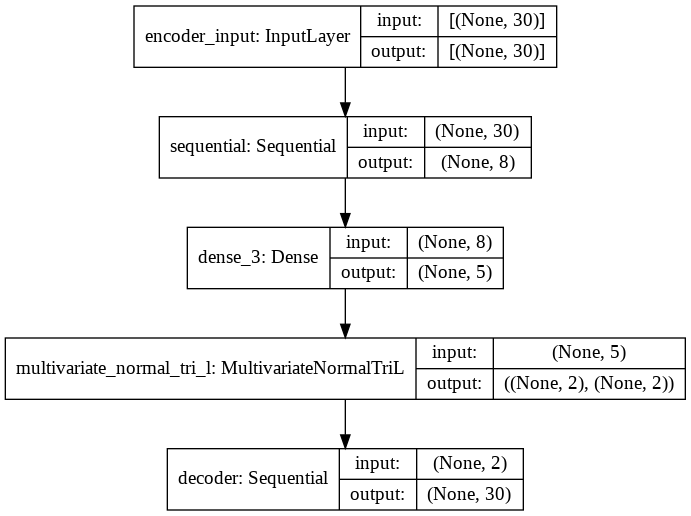

In [53]:
plot_model(vae,to_file='vae_mlp.png',show_shapes=True)

In [0]:
x = data.drop(["Class"], axis=1)
y = data["Class"].values

x_norm, x_fraud = x.values[y == 0], x.values[y == 1]

x_norm_sample = x_norm[np.random.randint(x_norm.shape[0], size=100000), :]
x_norm_train_sample, x_norm_val_sample = train_test_split(x_norm_sample, test_size=0.2)

In [0]:
tf_train = tf.data.Dataset.from_tensor_slices((x_norm_train_sample, x_norm_train_sample)).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE).shuffle(int(10e4))
tf_val = tf.data.Dataset.from_tensor_slices((x_norm_val_sample, x_norm_val_sample)).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE).shuffle(int(10e4))

In [58]:
print(x.shape)
print(y.shape)
print(x_norm.shape)
print(x_fraud.shape)
print(x_norm_sample.shape)
print(x_norm_train_sample.shape)
print(x_norm_val_sample.shape)

(213605, 30)
(213605,)
(213233, 30)
(372, 30)
(100000, 30)
(80000, 30)
(20000, 30)


In [0]:
#len(y[y==1])

In [0]:
checkpointer = ModelCheckpoint(filepath='bestmodel.h5', verbose=0, save_best_only=True)
earlystopper = EarlyStopping(monitor='val_loss', mode='min', min_delta=0.005, patience=20, verbose=0, restore_best_weights=True)

In [0]:
hist = vae.fit(tf_train,epochs=max_epochs,shuffle=True,verbose=0,validation_data=tf_val,callbacks=[checkpointer, earlystopper])

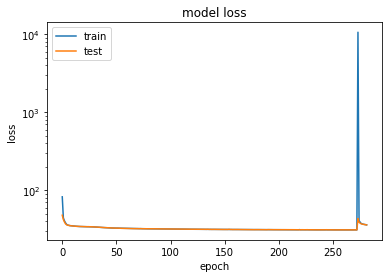

In [72]:
plot_loss(hist)